In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='7bb82b7e-8a0f-4854-aac0-182e777a31bb', project_access_token='p-261bcd06faa60bd899ecbd4f9c1746c366285a8b')


# Exploratory Data Analysis of NOAA Weather Data 

This notebook relates to the NOAA Weather Dataset - JFK Airport (New York). The dataset contains 114,546 hourly observations of 12 local climatological variables (such as temperature and wind speed) collected at JFK airport. This dataset can be obtained for free from the IBM Developer [Data Asset Exchange](https://developer.ibm.com/exchanges/data/all/jfk-weather-data/).

In this notebook we visualize and analyze the weather time-series dataset.

### Table of Contents:
* [0. Prerequisites](#cell0)
* [1. Read the Cleaned Data](#cell1)
* [2. Visualize the Data](#cell2)
* [3. Analyze Trends in the Data](#cell3)
* [Authors](#authors)


<a id="cell0"></a>
### 0. Prerequisites

Before you run this notebook complete the following steps:
- Insert a project token
- Install and import required packages

#### Insert a project token

When you import this project from the Watson Studio Gallery, a token should be automatically generated and inserted at the top of this notebook as a code cell such as the one below:

```python
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='YOUR_PROJECT_ID', project_access_token='YOUR_PROJECT_TOKEN')
pc = project.project_context
```

If you do not see the cell above, follow these steps to enable the notebook to access the dataset from the project's resources:

* Click on `More -> Insert project token` in the top-right menu section

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

* This should insert a cell at the top of this notebook similar to the example given above.

  > If an error is displayed indicating that no project token is defined, follow [these instructions](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/token.html?audience=wdp&context=data).

* Run the newly inserted cell before proceeding with the notebook execution below

#### Import required packages

Install and import the required packages:

* pandas
* matplotlib
* seaborn
* numpy

In [2]:
# Installing packages needed for data processing and visualization
!pip install pandas matplotlib seaborn numpy 

In [3]:
# Importing the packages
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame as df
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 160

<a id="cell1"></a>

### 1. Read the Cleaned Data

We start by reading in the cleaned dataset that was created in the project notebook `Part 1 - Data Cleaning`. 

*Note* if you haven't yet run that notebook, do that first otherwise the cells below will not work.

In [4]:
def get_file_handle(fname):
    # Project data path for the raw data file
    data_path = project.get_file(fname)
    data_path.seek(0)
    return data_path

# Using pandas to read the data 
# Since the `DATE` column consists date-time information, we use Pandas parse_dates keyword for easier data processing
data_path = get_file_handle('jfk_weather_cleaned.csv')
data = pd.read_csv(data_path, parse_dates=['DATE'])
# Set date index
data = data.set_index(pd.DatetimeIndex(data['DATE']))
data.drop(['DATE'], axis=1, inplace=True)
data.head()

,visibility,dry_bulb_temp_f,wet_bulb_temp_f,dew_point_temp_f,relative_humidity,wind_speed,station_pressure,sea_level_pressure,precip,altimeter_setting,wind_direction_sin,wind_direction_cos
DATE,,,,,,,,,,,,
2010-01-01 01:00:00,6.0,33.0,32.0,31.0,92.0,0.0,0.0,29.97,8,29.99,0.01,29.99
2010-01-01 02:00:00,6.0,33.0,33.0,32.0,96.0,0.0,0.0,29.97,8,29.99,0.02,29.99
2010-01-01 03:00:00,5.0,33.0,33.0,32.0,96.0,0.0,0.0,29.97,8,29.99,0.00,29.99
2010-01-01 04:00:00,5.0,33.0,33.0,32.0,96.0,0.0,0.0,29.95,8,29.97,0.00,29.97
2010-01-01 05:00:00,5.0,33.0,32.0,31.0,92.0,0.0,0.0,29.93,8,29.96,0.00,29.95


<a id="cell2"></a>

### 2. Visualize the Data

In this section we visualize a few sections of the data, using `matplotlib`'s `pyplot` module. 


In [5]:
# Columns to visualize
plot_cols = ['dry_bulb_temp_f', 'relative_humidity', 'wind_speed', 'station_pressure', 'precip']

#### Quick Peek at the Data

We first visualize all the data we have to get a rough idea about how the data looks like. 

As we can see in the plot below, the hourly temperatures follow a clear seasonal trend. Wind speed, pressure, humidity and precipitation data seem to have much higher variance and randomness.

It might be more meaningful to make a model to predict temperature, rather than some of the other more noisy data columns. 

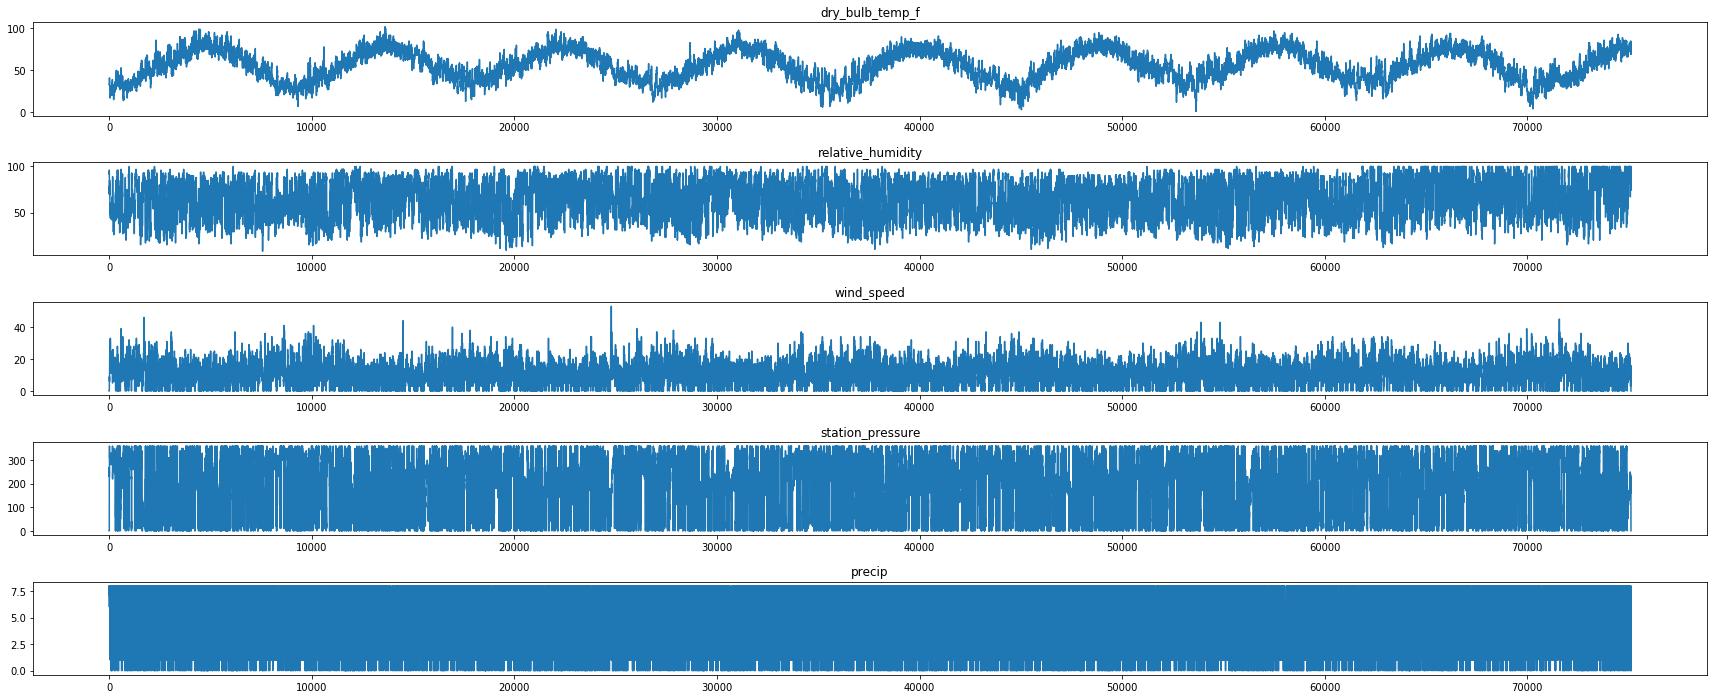

In [6]:
# Quick overview of columns
plt.figure(figsize=(30, 12))
i = 1
for col in plot_cols:
    plt.subplot(len(plot_cols), 1, i)
    plt.plot(data[col].values)
    plt.title(col)
    i += 1
plt.subplots_adjust(hspace=0.5)
plt.show()

#### Feature Dependencies

Now we explore how the features (columns) of our data are related to each other. This helps in deciding which features to use when modelling a classifier or regresser. 
We ideally want independent features to be classified independently and likewise dependent features to be contributing to the same model. 

We can see from the correlation plots how some features are somewhat correlated and could be used as additional data (perhaps for augmenting) when training a classifier. 

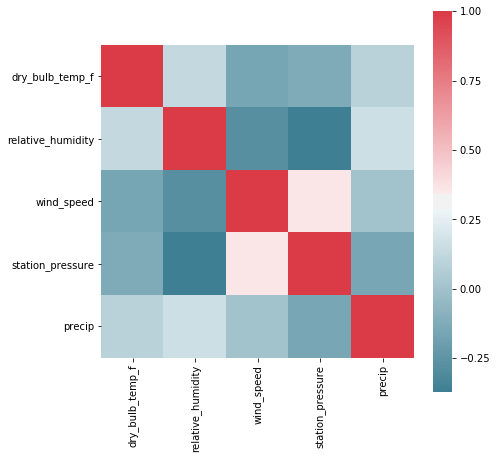

In [7]:
# Plot correlation matrix
f, ax = plt.subplots(figsize=(7, 7))
corr = data[plot_cols].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax);

Additionally we also visualize the joint distrubitions in the form of pairplots/scatter plots to see (qualitatively) the way in which these features are related in more detail over just the correlation.
They are essentially 2D joint distributions in the case of off-diagonal subplots and the histogram (an approximation to the probability distribution) in case of the diagonal subplots.

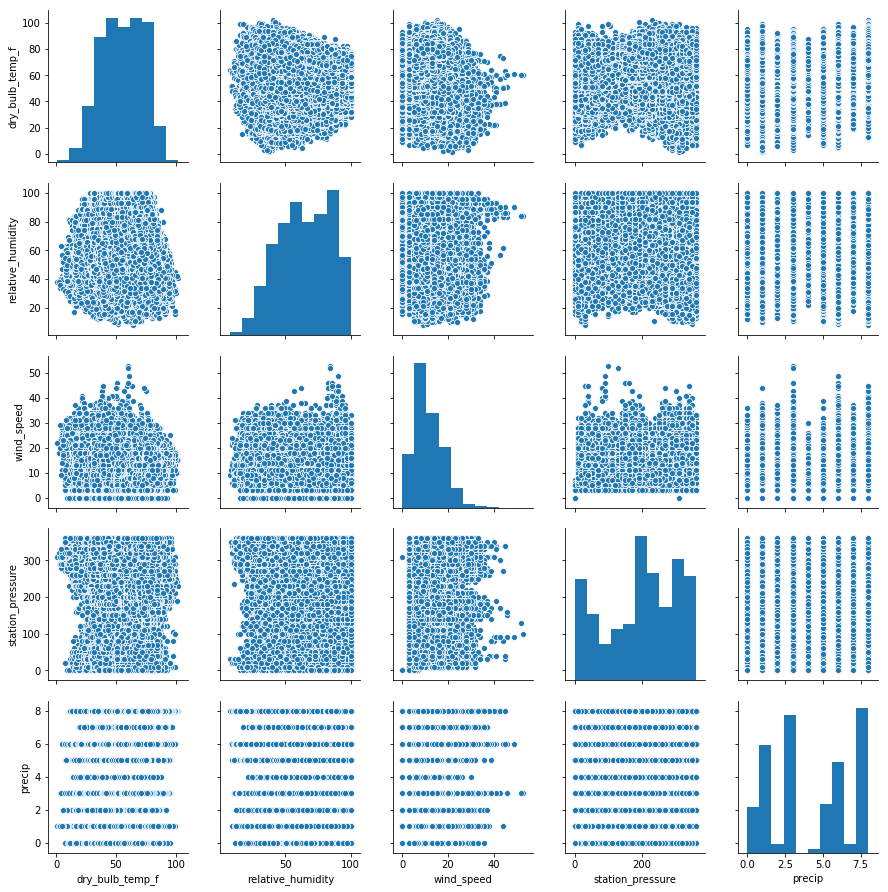

In [8]:
# Plot pairplots
sns.pairplot(data[plot_cols])

<a id="cell3"></a>

### 3. Analyze Trends in the Data

Now that we have explored the whole dataset and the features on a high level, let us focus on one particular feature - `dry_bulb_temp_f`, the dry bulb temperature in degrees Fahrenheit. This is what we mean when we refer to "air temperature". This is the most common feature used in temperature prediction, and here we explore it in further detail. 

We first start with plotting the data for all 9 years in monthly buckets then drill down to a single year to notice (qualitatively) the overall trend in the data. We can see from the plots that every year has roughly a sinousoidal nature to the temperature with some anomalies around 2013-2014. Upon further drilling down we see that each year's data is not the smooth sinousoid but rather a jagged and noisy one. But the overall trend still is a sinousoid. 

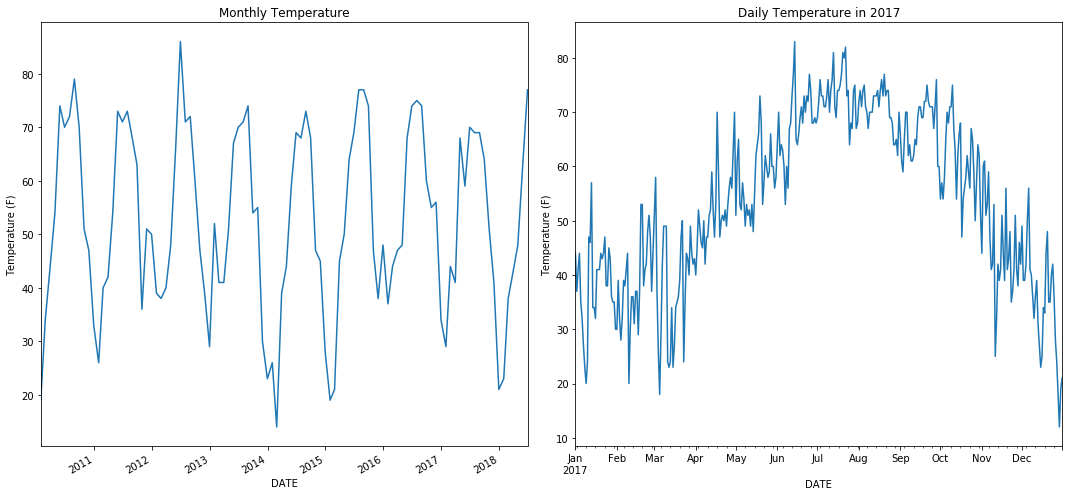

In [9]:
plt.figure(figsize=(15,7))

TEMP_COL = 'dry_bulb_temp_f'
# Plot temperature data converted to a monthly frequency 
plt.subplot(1, 2, 1)
data[TEMP_COL].asfreq('M').plot()  
plt.title('Monthly Temperature')
plt.ylabel('Temperature (F)')

# Zoom in on a year and plot temperature data converted to a daily frequency 
plt.subplot(1, 2, 2)
data['2017'][TEMP_COL].asfreq('D').plot()  
plt.title('Daily Temperature in 2017')
plt.ylabel('Temperature (F)')

plt.tight_layout()
plt.show()

Next, we plot the change (delta) in temperature and notice that it is lowest around the middle of the year. That is expected behaviour as the gradient of the sinousoid near it's peak is zero. 

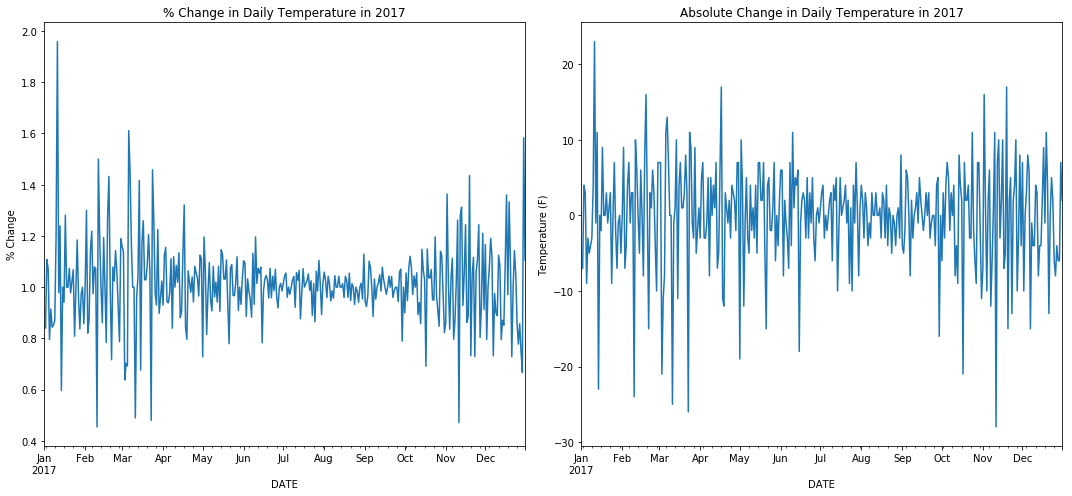

In [10]:
plt.figure(figsize=(15,7))

# Plot percent change of daily temperature in 2017
plt.subplot(1, 2, 1)
data['2017'][TEMP_COL].asfreq('D').div(data['2017'][TEMP_COL].asfreq('D').shift()).plot()
plt.title('% Change in Daily Temperature in 2017')
plt.ylabel('% Change')

# Plot absolute change of temperature in 2017 with daily frequency
plt.subplot(1, 2, 2)
data['2017'][TEMP_COL].asfreq('D').diff().plot()
plt.title('Absolute Change in Daily Temperature in 2017')
plt.ylabel('Temperature (F)')

plt.tight_layout()
plt.show()

Finally we apply some smoothing to the data in the form of a rolling/moving average. This is the simplest form of de-noising the data. As we can see from the plots, the average (plotted in blue) roughly traces the sinousoid and is now much smoother. This can improve the accuracy of a regression model trained to predict temperatures within a reasonable margin of error. 

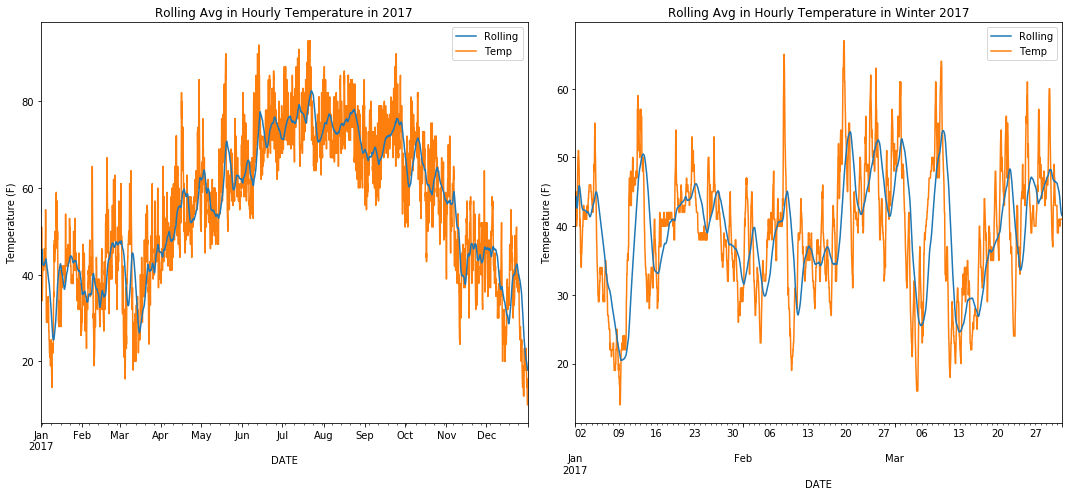

In [11]:
plt.figure(figsize=(15,7))

# Plot rolling mean of temperature 
plt.subplot(1, 2, 1)
data['2017'][TEMP_COL].rolling('5D').mean().plot(zorder=2) # Rolling average window is 5 days
data['2017'][TEMP_COL].plot(zorder=1)
plt.legend(['Rolling','Temp'])
plt.title('Rolling Avg in Hourly Temperature in 2017')
plt.ylabel('Temperature (F)')

# Plot rolling mean of temperature
plt.subplot(1, 2, 2)
data['2017-01':'2017-03'][TEMP_COL].rolling('2D').mean().plot(zorder=2) # Rolling average window is 2 days
data['2017-01':'2017-03'][TEMP_COL].plot(zorder=1)
plt.legend(['Rolling','Temp'])
plt.title('Rolling Avg in Hourly Temperature in Winter 2017')
plt.ylabel('Temperature (F)')

plt.tight_layout()
plt.show()

#### Next steps

- Close this notebook.
- Open the `Part 3 - Time Series Forecasting` notebook to create time-series models to forecast temperatures.

<a id="authors"></a> 
### Authors

This notebook was created by the [Center for Open-Source Data & AI Technologies](http://codait.org).
<br><br>

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.
<br><br>
<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>

# Coursera - Week 3 Peer-Graded Assignement - Jupyter notebook

# Content:  
# Part 1: Data Cleaning
# Part 2: Data analysis